# Section average 
Global average or basin average, confidence interval using error propagation

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import scipy.io as sio
import os
import matplotlib.pyplot as plt

In [2]:
def err_from_mean(var, var_err, var_eDOF, confidence_level=0.95):
    """assume all variables are independent, 
    can use error propagation to compute the error of the mean,
    given error of each variables
    
    eDOF = sum(eDOF)
    
    var: (LL_st, z_N2) or (z_N2)
    """
    
    import scipy.stats
    
    if len(var.shape) == 2:
        var_mean_ = np.zeros(len(var[0,:]),) + np.nan
        var_err_ = np.zeros(len(var[0,:]),) + np.nan
        var_CI_ = np.zeros((len(var[0,:]),2)) + np.nan
        for i in range(len(var[0,:])):
            idx_good = (~np.isnan(var_err[:,i])) & (~np.isinf(var_err[:,i]))
            if len(var_err[idx_good,i])>0:
                var_mean_[i] = np.mean(var[idx_good,i])
                var_err_[i] = np.sqrt(np.sum(var_err[idx_good,i]**2))/len(var_err[idx_good,i])
                var_CI_[i,:] = scipy.stats.t.interval(confidence_level, np.sum(var_eDOF[idx_good,i]), var_mean_[i], var_err_[i]) 
    else:
        idx_good = (~np.isnan(var_err)) & (~np.isinf(var_err))
        if len(var_err[idx_good])>0:
            var_mean_ = np.mean(var[idx_good])
            var_err_ = np.sqrt(np.sum(var_err[idx_good]**2))/len(var_err[idx_good])
            var_CI_ = scipy.stats.t.interval(confidence_level, np.sum(var_eDOF[idx_good]), var_mean_, var_err_) 
        else:
            var_mean_ = np.nan
            var_err_ = np.nan
            var_CI_ = np.array([np.nan, np.nan])
                
    return var_mean_, var_err_, var_CI_

In [3]:
def Basin_data(datafilepath, section_name, section_loc, method, data_name, var_name):
    """method = 1: lon section
       method = 0, lat section """
    from scipy.interpolate import interp1d
    
    count = 0
    for i in range(len(section_name)):
        acquisition = section_name[i]
        try:
            count += 1
            Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_" + data_name + ".nc")
            if count == 1:
                var = eval("Data_trend."+var_name+"_mean.data")
                var_err = eval("Data_trend."+var_name+"_err.data")
                var_eDOF = eval("Data_trend.eDOF.data")
                if method[i]:
                    var_lat = Data_trend.LL_st.data
                    f = interp1d(section_loc[i][0], section_loc[i][1], bounds_error=False, fill_value="extrapolate")
                    var_lon = f(var_lat)
                else:
                    var_lon = Data_trend.LL_st.data
                    f = interp1d(section_loc[i][0], section_loc[i][1], bounds_error=False, fill_value="extrapolate")
                    var_lat = f(var_lon)

            else:
                var = np.vstack((eval("Data_trend."+var_name+"_mean.data"), var))
                var_err = np.vstack((eval("Data_trend."+var_name+"_err.data"), var_err))
                var_eDOF = np.vstack((eval("Data_trend.eDOF.data"), var_eDOF))
                if method[i]:
                    var_lat = np.hstack((Data_trend.LL_st.data, var_lat))
                    f = interp1d(section_loc[i][0], section_loc[i][1], bounds_error=False, fill_value="extrapolate")
                    var_lon = np.hstack((f(Data_trend.LL_st.data), var_lon))
                else:
                    var_lon = np.hstack((Data_trend.LL_st.data, var_lon))
                    f = interp1d(section_loc[i][0], section_loc[i][1], bounds_error=False, fill_value="extrapolate")
                    var_lat = np.hstack((f(Data_trend.LL_st.data), var_lat))
        except FileNotFoundError:
            pass
    
    var_lon[var_lon<0]+=360
            
    return var, var_err, var_eDOF, var_lat, var_lon


In [4]:
def mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method, qc=0, confidence_level=0.95):
    """qc = 1: get rid of ratio > 50%"""
    if qc:
        if method == 1:
            var0 = var[idx_basin, :][:, idx_range].flatten()/N2_z_[idx_basin, :][:, idx_range].flatten()
            var__, var_err__, var_CI__ = err_from_mean(var0[np.abs(var0)<.5],
                                                   (var_err[idx_basin, :][:, idx_range].flatten()/N2_z_[idx_basin, :][:, idx_range].flatten())[np.abs(var0)<.5],
                                                   var_eDOF[idx_basin, :][:, idx_range].flatten()[np.abs(var0)<.5], confidence_level)
        elif method == 2:
            var_, var_err_, var_CI_ = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                                                   var_err[idx_basin, :][:, idx_range].flatten(),
                                                   var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level)
            var__ = var_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
            var_err__ = var_err_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
            var_CI__ = var_CI_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
        elif method == 3:
            var0 = (var[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten()
            var__, var_err__, var_CI__ = err_from_mean(var0[np.abs(var0)<.5],
                                                   (var_err[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten()[np.abs(var0)<.5],
                                                   var_eDOF[idx_basin, :][:, idx_range].flatten()[np.abs(var0)<.5], confidence_level)
    else:        
        if method == 1:
            var__, var_err__, var_CI__ = err_from_mean(var[idx_basin, :][:, idx_range].flatten()/N2_z_[idx_basin, :][:, idx_range].flatten(),
                                                   var_err[idx_basin, :][:, idx_range].flatten()/N2_z_[idx_basin, :][:, idx_range].flatten(),
                                                   var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level)     
        elif method == 2:
            var_, var_err_, var_CI_ = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                                                   var_err[idx_basin, :][:, idx_range].flatten(),
                                                   var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level)
            var__ = var_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
            var_err__ = var_err_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
            var_CI__ = var_CI_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
        elif method == 3:
            var__, var_err__, var_CI__ = err_from_mean((var[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
                                                   (var_err[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
                                                   var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level)
    
    return var__, var_CI__



def mean_in_basin(var, var_err, var_eDOF, N2_z_, idx_basin, method, qc=0, confidence_level=0.95):
    """qc = 1: get rid of ratio > 50%"""
    if qc:
        if method == 1:
            var0 = var[idx_basin, :]/N2_z_[idx_basin, :]
            var0_err = var_err[idx_basin, :]/N2_z_[idx_basin, :]
            var0_eDOF = var_eDOF[idx_basin, :]
            if len(var0_err[np.abs(var0)>=.5])>0:
                var0_err[np.abs(var0)>=.5] = np.nan
                var0_eDOF[np.abs(var0)>=.5] = np.nan
                var0[np.abs(var0)>=.5] = np.nan  
            var__, var_err__, var_CI__ = err_from_mean(var0,
                                                   var0_err,
                                                   var0_eDOF, confidence_level)     
        elif method == 2:
            var_, var_err_, var_CI_ = err_from_mean(var[idx_basin, :],
                                                   var_err[idx_basin, :],
                                                   var_eDOF[idx_basin, :], confidence_level)
            var__ = var_/np.nanmean(N2_z_[idx_basin, :], axis=0)
            var_err__ = var_err_/np.nanmean(N2_z_[idx_basin, :], axis=0)
            var_CI__ = np.array([var_CI_[:,0]/np.nanmean(N2_z_[idx_basin, :], axis=0), var_CI_[:,1]/np.nanmean(N2_z_[idx_basin, :], axis=0)]).T                                                         
        elif method == 3:
            var0 = var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0)
            var0_err = var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0)
            var0_eDOF = var_eDOF[idx_basin, :]
            if len(var0_err[np.abs(var0)>=.5])>0:
                var0_err[np.abs(var0)>=.5] = np.nan
                var0_eDOF[np.abs(var0)>=.5] = np.nan
                var0[np.abs(var0)>=.5] = np.nan            
            var__, var_err__, var_CI__ = err_from_mean(var0,
                                                   var0_err,
                                                   var0_eDOF, confidence_level)     
    else:
        if method == 1:
            var__, var_err__, var_CI__ = err_from_mean(var[idx_basin, :]/N2_z_[idx_basin, :],
                                                   var_err[idx_basin, :]/N2_z_[idx_basin, :],
                                                   var_eDOF[idx_basin, :], confidence_level)     
        elif method == 2:
            var_, var_err_, var_CI_ = err_from_mean(var[idx_basin, :],
                                                   var_err[idx_basin, :],
                                                   var_eDOF[idx_basin, :], confidence_level)
            var__ = var_/np.nanmean(N2_z_[idx_basin, :], axis=0)
            var_err__ = var_err_/np.nanmean(N2_z_[idx_basin, :], axis=0)
            var_CI__ = np.array([var_CI_[:,0]/np.nanmean(N2_z_[idx_basin, :], axis=0), var_CI_[:,1]/np.nanmean(N2_z_[idx_basin, :], axis=0)]).T                                                         
        elif method == 3:
            var__, var_err__, var_CI__ = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0),
                                                   var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0),
                                                   var_eDOF[idx_basin, :], confidence_level)

        
    return var__, var_CI__

## Parameters

In [5]:
# path to WOCE read trend results
resultfilepath = '../results/'
datafilepath = '/Users/stan/Desktop/WORK/DATA/GOSHIP/EasyOcean/gridded/'
# path to saved data
outfilepath = '../figure/'

param_plot = {"z1_up": 2000,
              "z2_up": 0,
              "z1_lw": 6000,
              "z2_lw": 2000,
              "sig1_up": 45.65,
              "sig2_up": 43,
              "sig1_lw": 46.25,
              "sig2_lw": 45.95,
              "vlim1": [-1e-7,1e-7],
              "vlim2": [-1e-7,1e-7],
              "vlim_factor1": [.8,1.2],
              "vlim_factor2": [.8,1.2],
            }

# location info
import pickle
loc_info = open(resultfilepath + 'EasyOcean_location.obj', 'rb')
loc = pickle.load(loc_info)
loc_info.close()

# default way to compute confidence interval of factors
method_mean = 3

In [6]:
section_name = loc["lon_sec"] + loc["lat_sec"]
# section_loc = np.hstack((loc['loc_lon_sec'], loc['loc_lat_sec']))
section_loc = [*loc["loc_lon_all"], *loc["loc_lat_all"]]
method = np.hstack((np.ones(loc['loc_lon_sec'].shape), np.zeros(loc['loc_lat_sec'].shape))).astype('bool')
var, var_err, var_eDOF, var_lat, var_lon = Basin_data(
    datafilepath,
    section_name, 
    section_loc, 
    method, 
    "sig4_trend", 
    "trend_N2")
z_thred = [45.7, 45.95]

In [7]:
count = 0
for i in range(len(section_name)):
    acquisition = section_name[i]
    try:
        count += 1
        Data_block = xr.open_dataset(datafilepath + acquisition.lower() + "_sig4_block.nc")
        if count == 1:
            N2_z_ = Data_block.N2_mean[0,:,:].data
        else:
            N2_z_ = np.vstack((Data_block.N2_mean[0,:,:].data, N2_z_))

    except FileNotFoundError:
        pass


count = 0
for i in range(len(section_name)):
    acquisition = section_name[i]
    try:
        count += 1
        Data_block = xr.open_dataset(datafilepath + acquisition.lower() + "_sig4_block.nc")
        if count == 1:
            N2_z__ = Data_block.N2_mean.mean(axis=0, skipna=True).data
        else:
            N2_z__ = np.vstack((Data_block.N2_mean.mean(axis=0, skipna=True).data, N2_z__))

    except FileNotFoundError:
        pass

z_N2 = np.round(Data_block.z_N2.data, 3)
N2_z_.shape, N2_z__.shape, var.shape

((588, 33), (588, 33), (588, 33))

## Main Program

### 1. South of 60S, SH, NH

----------south of 60$^{\circ}$S----------
max N2 : -5.586401720871864e-07 (-2.6951939156312544e-06,1.5779135714568815e-06) at 45.825 m
mean 45.7 m $\leq z \leq$45.95 m: -0.2% (-20.3%,19.8%)
mean 45.7 m $\leq z \leq$45.95 m:,  7.147765316559663e-08, (-5.391597848961038e-07,6.821150912272971e-07)
mean $z\geq$45.95 m: 2.3% (-44.2%,48.9%)
mean $z\geq$45.95 m:,  -2.4363992824043808e-08, (-2.711899205313839e-07,2.224619348832963e-07)
max N2 factor change:-28.3%(-136.6%,80.0%) at 45.825 m
----------Southern Hemisphere----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:34: RuntimeWarning: Mean of empty slice
  var__, var_err__, var_CI__ = err_from_mean((var[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:35: RuntimeWarning: Mean of empty slice
  (var_err[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:87: RuntimeWarning: Mean of empty slice
  var__, var_err__, var_CI__ = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:88: RuntimeWarning: Mean of empty slice
  var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:34: RuntimeWarning: Mean of empty sli

max N2 : -1.243601121113973e-07 (-6.183145679778679e-07,3.695943437550733e-07) at 45.825 m
mean 45.7 m $\leq z \leq$45.95 m: -0.1% (-8.2%,8.0%)
mean 45.7 m $\leq z \leq$45.95 m:,  8.706743324800834e-09, (-1.335134233816014e-07,1.5092691003120308e-07)
mean $z\geq$45.95 m: -2.0% (-30.5%,26.6%)
mean $z\geq$45.95 m:,  -3.649867389258847e-08, (-1.8441234268502505e-07,1.1141499489984813e-07)
max N2 factor change:-10.5%(-52.2%,31.2%) at 45.825 m
----------Northern Hemisphere----------
max N2 : -8.81297842669658e-06 (-0.0022277199756148684,0.0022100940187614756) at 45.975 m
mean 45.7 m $\leq z \leq$45.95 m: 1.3% (-65.5%,68.1%)
mean 45.7 m $\leq z \leq$45.95 m:,  -7.609945482330005e-09, (-3.587113022297047e-07,3.434914112650447e-07)
mean $z\geq$45.95 m: -5.8% (-1613.6%,1602.0%)
mean $z\geq$45.95 m:,  8.661087498017732e-07, (-2.240302560035132e-05,2.4135243099954868e-05)
max N2 factor change:-443.7%(-112155.5%,111268.1%) at 45.975 m


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

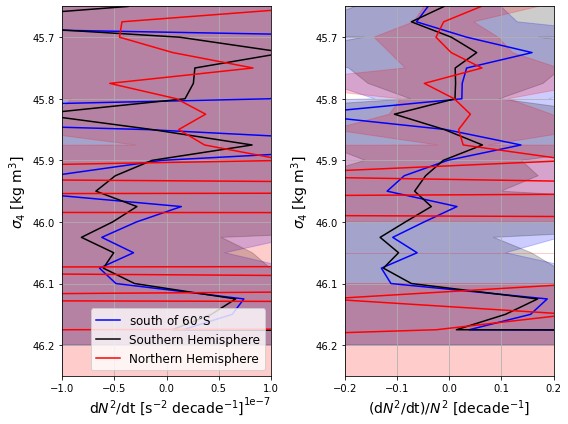

In [8]:
lat_st = [-90, -90, 0]
lat_ed = [-60, 0, 90]
colors = ['b', 'k', 'r']
labels = ['south of 60$^{\circ}$S', 'Southern Hemisphere', 'Northern Hemisphere']
section_name = loc["lon_sec"] + loc["lat_sec"]
section_loc = [*loc["loc_lon_all"], *loc["loc_lat_all"]]
method = np.hstack((np.ones(loc['loc_lon_sec'].shape), np.zeros(loc['loc_lat_sec'].shape))).astype('bool')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,6), sharey=False, sharex=False)
for i in range(len(lat_st)):
    print(10*'-'+labels[i]+10*'-')
    lat_range = [lat_st[i], lat_ed[i]]
    idx_basin = (var_lat>=lat_range[0]) & (var_lat<=lat_range[1])
    N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :], var_err[idx_basin, :], var_eDOF[idx_basin, :])
    ax[0].plot(N2_trend_z, z_N2, color=colors[i], label=labels[i])
    ax[0].fill_betweenx(z_N2, 
                     N2_trend_CI_z[:,0],
                     N2_trend_CI_z[:,1],
                     color=colors[i], alpha=.2)  
    ax[0].set_ylim([param_plot['sig1_lw'], param_plot['sig1_up']])
    ax[0].set_xlim(param_plot['vlim1'])
    ax[0].grid(True)
    ax[0].set_ylabel('$\sigma_4$ [kg m$^3$]', fontsize=14)
    ax[0].set_xlabel('d$N^2$/dt [s$^{-2}$ decade$^{-1}$]', fontsize=14)
    ax[0].legend(fontsize=12)
    idx = np.where(N2_trend_z[z_N2>=z_thred[0]]==np.nanmin(N2_trend_z[z_N2>=z_thred[0]]))[0][0]
    print(f"max N2 : {(np.nanmin(N2_trend_z[z_N2>=z_thred[0]]))} ({N2_trend_CI_z[z_N2>=z_thred[0],0][idx]},{N2_trend_CI_z[z_N2>=z_thred[0],1][idx]}) at {z_N2[z_N2>=z_thred[0]][idx]} m")

    for k in range(len(z_thred)):
        if k == 1:
            idx_range = (z_N2>=z_thred[1])
        elif k == 0: 
            idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])

        # factor change
        var_, var_CI_ = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean)
        if k == 1:
            print(f'mean $z\geq${z_thred[k]} m:',  "{:.1%}".format(var_), '('+"{:.1%}".format(var_CI_[0])+','+"{:.1%}".format(var_CI_[1])+')')
        elif k == 0:
            print(f'mean {z_thred[0]} m $\leq z \leq${z_thred[1]} m:',  "{:.1%}".format(var_), '('+"{:.1%}".format(var_CI_[0])+','+"{:.1%}".format(var_CI_[1])+')')

        # absolute change
        var_, var_err_, var_CI_ = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                                   var_err[idx_basin, :][:, idx_range].flatten(),
                                   var_eDOF[idx_basin, :][:, idx_range].flatten())
        if k == 1:
            print(f'mean $z\geq${z_thred[k]} m:,  {var_}, ({var_CI_[0]},{var_CI_[1]})')
        elif k == 0:
            print(f'mean {z_thred[0]} m $\leq z \leq${z_thred[1]} m:,  {var_}, ({var_CI_[0]},{var_CI_[1]})')

    
    var_, var_CI_ = mean_in_basin(var, var_err, var_eDOF, N2_z_, idx_basin, method_mean)
    print(f"max N2 factor change:"+ "{:.1%}".format(var_[z_N2>=z_thred[0]][idx])+ "("+"{:.1%}".format(var_CI_[z_N2>=z_thred[0],0][idx])+','+"{:.1%}".format(var_CI_[z_N2>=z_thred[0],1][idx]) + f") at {z_N2[z_N2>=z_thred[0]][idx]} m")
    ax[1].plot(var_, z_N2, color=colors[i])
    ax[1].fill_betweenx(z_N2, 
                     var_CI_[:,0],
                     var_CI_[:,1],
                     color=colors[i], alpha=.2)  
    ax[1].set_ylim([param_plot['sig1_lw'], param_plot['sig1_up']])
    ax[1].set_xlim([-.2, .2])
    ax[1].grid(True)
    ax[1].set_ylabel('$\sigma_4$ [kg m$^3$]', fontsize=14)
    ax[1].set_xlabel('(d$N^2$/dt)/$N^2$ [decade$^{-1}$]', fontsize=14)

plt.tight_layout()
plt.savefig(outfilepath + f'Global_mean_N2trend_sig4.jpeg', dpi=300)
plt.savefig(outfilepath + f'Global_mean_N2trend_sig4.eps')

In [9]:
i = 0
lat_range = [lat_st[i], lat_ed[i]]
idx_basin = (var_lat>=lat_range[0]) & (var_lat<=lat_range[1])
N2_trend_z_sh, N2_trend_err_z_sh, N2_trend_CI_z_sh = err_from_mean(var[idx_basin, :], var_err[idx_basin, :], var_eDOF[idx_basin, :])
N2_trend_z_sh_percentage, N2_trend_CI_z_sh_percentage = mean_in_basin(var, var_err, var_eDOF, N2_z_, idx_basin, method_mean)


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:87: RuntimeWarning: Mean of empty slice
  var__, var_err__, var_CI__ = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:88: RuntimeWarning: Mean of empty slice
  var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0),


### 2. Each basin

In [10]:
def within_basin(var_lon, var_lat, k):
    """input an arry of lon and lat, output mask for the kth basin in the basin boundary data from Purkey and Johnson (2010)
    https://stackoverflow.com/questions/3654289/scipy-create-2d-polygon-mask
    """
    
    basin = sio.loadmat('../data/bsn_boundary.mat', squeeze_me=True, struct_as_record=False)

    keys = {0: ['GB', 'Guatemala basin'],
    1: ['', ''],
    2: ['PER', 'Peru basin'],
    3: ['CHI', 'Chile basin'], 
    4: ['SWP', 'Southwest Pacific basin'], 
    5: ['', ''],
    6: ['ABB', 'Amundsen‐Bellingshausen basin'],
    7: ['CS', 'Coral Sea'], 
    8: ['PB', 'Pacific basin'], 
    9: ['TAS', 'Tasman Sea'],
    10: ['SB', 'Somali basin'],
    11: ['SAB', 'South Australian basin'], 
    12: ['OS', 'Okhotsk Sea'],
    13: ['BS', 'Bering Sea'],
    14: ['ARG', 'Argentine basin'],
    15: ['BB', 'Brazil basin'],
    16: ['', ''],
    17: ['NAB', 'North Atlantic basin'],
    18: ['AGU', 'Agulhas–Mozambique basin'],
    19: ['ANG', 'Angola basin'],
    20: ['IB', 'Iberian/Canary/Cape Verde basin'], 
    21: ['AS', 'Arabian Sea'],
    22: ['WEB', 'Weddell–Enderby basin'],
    23: ['CAP', 'Cape basin'], 
    24: ['', ''],
    25: ['SS', 'Scotia Sea'], 
    26: ['MB', 'Madagascar basin'], 
    27: ['MIB', 'mid-Indian basin'], 
    28: ['WB', 'Wharton basin'], 
    29: ['CRO', 'Crozet basin'], 
    30: ['AAB', 'Australian-Antarctic basin'], 
    31: ['PHI', 'Philippine basin'], 
    32: ['ECS', 'east of Coral Sea'], }
    
    var_lon_ = var_lon.copy()
    var_lat_ = var_lat.copy()
    
    from matplotlib.path import Path
    for i in range(len(basin['bsn_only'][k].bsn[0])):
        if i == 0:
            basin_verts = [(basin['bsn_only'][k].bsn[0][i], basin['bsn_only'][k].bsn[1][i])]
        else:
            basin_verts.append((basin['bsn_only'][k].bsn[0][i], basin['bsn_only'][k].bsn[1][i]))
    basin_path = Path(basin_verts)
    if k == 19 | k == 23:
        var_lon_[var_lon_<basin['bsn_only'][k].bsn[0].max() - 360]+=360
    if k == 22:
        var_lon_[var_lon_>basin['bsn_only'][k].bsn[0].min() + 360]-=360
        
    var_mask = basin_path.contains_points(np.vstack((var_lon_,var_lat_)).T)
    
    return var_mask, keys

In [11]:
idx_ = np.array(([26, 27, 28, 8, 2, 3, 15, 19, 23], [29, 11, 30, np.nan, 4, 6, 14, 22, 18]))
idx__ = idx_.flatten()
bas_names = []
    
N2_trend = np.zeros((len(idx__), len(z_thred)))
N2_trend_CI_95 = np.zeros((len(idx__), len(z_thred), 2))
N2_trend_CI_85 = np.zeros((len(idx__), len(z_thred), 2))
N2_trend_CI_68 = np.zeros((len(idx__), len(z_thred), 2))

N2_trend_percentage = np.zeros((len(idx__), len(z_thred), 3))
N2_trend_percentage_CI_95 = np.zeros((len(idx__), len(z_thred), 3, 2))
N2_trend_percentage_CI_85 = np.zeros((len(idx__), len(z_thred), 3, 2))
N2_trend_percentage_CI_68 = np.zeros((len(idx__), len(z_thred), 3, 2))

for idx in range(len(idx__)):
    if np.isnan(idx__[idx]):        
        idx_basin1, _ = within_basin(var_lon, var_lat, 9)
        idx_basin2, _ = within_basin(var_lon, var_lat, 7)
        idx_basin3, _ = within_basin(var_lon, var_lat, 32)
        idx_basin = (idx_basin1) | (idx_basin2) | (idx_basin3)
        bas_names += ['TS+CS+ECS']
    else:
        idx_basin, var_keys = within_basin(var_lon, var_lat, int(idx__[idx]))
        bas_names += [var_keys[idx__[idx]][0]]
        
    for k in range(len(z_thred)):
        if k == 1:
            idx_range = (z_N2>=z_thred[1])
        elif k == 0: 
            idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])
        for method_mean in [1, 2, 3]:    
            N2_trend_percentage[idx,k,method_mean-1], N2_trend_percentage_CI_95[idx,k,method_mean-1,:] = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean)       
            _, N2_trend_percentage_CI_85[idx,k,method_mean-1,:] = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean, confidence_level=.85)
            _, N2_trend_percentage_CI_68[idx,k,method_mean-1,:] = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean, confidence_level=.68)

        N2_trend[idx,k], _, N2_trend_CI_95[idx,k,:] = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                       var_err[idx_basin, :][:, idx_range].flatten(),
                       var_eDOF[idx_basin, :][:, idx_range].flatten())
        _, _, N2_trend_CI_85[idx,k,:] = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                       var_err[idx_basin, :][:, idx_range].flatten(),
                       var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level=.85)
        _, _, N2_trend_CI_68[idx,k,:] = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                       var_err[idx_basin, :][:, idx_range].flatten(),
                       var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level=.68)


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:34: RuntimeWarning: Mean of empty slice
  var__, var_err__, var_CI__ = err_from_mean((var[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:35: RuntimeWarning: Mean of empty slice
  (var_err[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:30: RuntimeWarning: Mean of empty slice
  var__ = var_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:31: RuntimeWarning: Mean of empty slice
  var_err__ = var_err_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:32: RuntimeWarning: Mean of empty slice
  var_CI__ = var_CI_/np.nanmean(N2

In [12]:
N2_trend_basin= xr.Dataset({'N2_trend': (['basin_names', 'z_thred'], N2_trend),
                            'N2_trend_CI_95': (['basin_names', 'z_thred', 'limits'], N2_trend_CI_95),
                            'N2_trend_CI_85': (['basin_names', 'z_thred', 'limits'], N2_trend_CI_85),
                            'N2_trend_CI_68': (['basin_names', 'z_thred', 'limits'], N2_trend_CI_68),
                            'N2_trend_percentage': (['basin_names', 'z_thred', 'method_mean'], N2_trend_percentage),
                            'N2_trend_percentage_CI_95': (['basin_names', 'z_thred', 'method_mean', 'limits'], N2_trend_percentage_CI_95),
                            'N2_trend_percentage_CI_85': (['basin_names', 'z_thred', 'method_mean', 'limits'], N2_trend_percentage_CI_85),
                            'N2_trend_percentage_CI_68': (['basin_names', 'z_thred', 'method_mean', 'limits'], N2_trend_percentage_CI_68),
                            },
                      coords={'basin_names': bas_names, 
                              'basin_idx': idx__, 
                              'z_thred': z_thred, 
                              'method_mean': np.array([1,2,3]),
                              'limits': np.array([0,1])},
                      attrs={'title': 'N2 change averaged in basins'})
N2_trend_basin.to_netcdf(resultfilepath+'N2_trend_basin_sig4.nc')

In [13]:
N2_trend_basin.N2_trend_percentage[:,:,-1].sel(basin_names='AAB'), N2_trend_basin.N2_trend_percentage[:,:,-1].sel(basin_names='ABB'), N2_trend_basin.N2_trend_percentage[:,:,-1].sel(basin_names='WEB')

(<xarray.DataArray 'N2_trend_percentage' (z_thred: 2)>
 array([-0.0568004 , -0.08980558])
 Coordinates:
     basin_names  <U9 'AAB'
   * z_thred      (z_thred) float64 45.7 45.95
     method_mean  int64 3,
 <xarray.DataArray 'N2_trend_percentage' (z_thred: 2)>
 array([-0.08985805, -0.08528623])
 Coordinates:
     basin_names  <U9 'ABB'
   * z_thred      (z_thred) float64 45.7 45.95
     method_mean  int64 3,
 <xarray.DataArray 'N2_trend_percentage' (z_thred: 2)>
 array([0.18291252, 0.21286494])
 Coordinates:
     basin_names  <U9 'WEB'
   * z_thred      (z_thred) float64 45.7 45.95
     method_mean  int64 3)

In [14]:
N2_trend_basin.N2_trend_percentage_CI_95[:,:,-1,0].to_pandas()

z_thred,45.70,45.95
basin_names,,
MB,-0.003727,-0.007481
MIB,-0.002144,-0.677958
WB,-0.025366,-0.207472
PB,-0.032286,-0.104021
PER,-0.021753,NaN
CHI,-0.019125,NaN
BB,-0.014688,-0.115938
ANG,-0.004316,NaN
CAP,-0.146201,-1.206925


In [15]:
N2_trend_basin.N2_trend_percentage_CI_95[:,:,-1,1].to_pandas()

z_thred,45.70,45.95
basin_names,,
MB,0.026604,0.068324
MIB,0.029129,0.031641
WB,0.026285,0.046993
PB,0.012933,0.049456
PER,0.006995,NaN
CHI,-0.002173,NaN
BB,0.010345,0.007112
ANG,0.024212,NaN
CAP,0.100713,0.925256


In [16]:
N2_trend_basin.N2_trend_percentage[:,:,-1].to_pandas()

z_thred,45.70,45.95
basin_names,,
MB,0.011439,0.030421
MIB,0.013492,-0.323158
WB,0.000460,-0.080239
PB,-0.009677,-0.027282
PER,-0.007379,NaN
CHI,-0.010649,NaN
BB,-0.002172,-0.054413
ANG,0.009948,NaN
CAP,-0.022744,-0.140835


In [17]:
idx_all = np.arange(len(var_keys))
N2_trend_all = np.zeros((len(idx_all), len(z_thred)))
N2_trend_all_CI_95 = np.zeros((len(idx_all), len(z_thred), 2))
N2_trend_all_CI_85 = np.zeros((len(idx_all), len(z_thred), 2))
N2_trend_all_CI_68 = np.zeros((len(idx_all), len(z_thred), 2))

N2_trend_all_percentage = np.zeros((len(idx_all), len(z_thred), 3))
N2_trend_all_percentage_CI_95 = np.zeros((len(idx_all), len(z_thred), 3, 2))
N2_trend_all_percentage_CI_85 = np.zeros((len(idx_all), len(z_thred), 3, 2))
N2_trend_all_percentage_CI_68 = np.zeros((len(idx_all), len(z_thred), 3, 2))

bas_names_all = []
for idx in range(len(var_keys)):
    bas_names_all += [var_keys[idx_all[idx]][0]]
    
for idx in range(len(idx_all)):
    if (idx_all[idx] == 9) | (idx_all[idx] == 7) | (idx_all[idx] == 32):
        idx_basin1, _ = within_basin(var_lon, var_lat, 9)
        idx_basin2, _ = within_basin(var_lon, var_lat, 7)
        idx_basin3, _ = within_basin(var_lon, var_lat, 32)
        idx_basin = (idx_basin1) | (idx_basin2) | (idx_basin3)
    else:
        idx_basin, var_keys = within_basin(var_lon, var_lat, int(idx_all[idx]))
        
    for k in range(len(z_thred)):
        if k == 1:
            idx_range = (z_N2>=z_thred[1])
        elif k == 0: 
            idx_range = (z_N2>=z_thred[0]) & (z_N2<z_thred[1])
        for method_mean in [1, 2, 3]:    
            N2_trend_all_percentage[idx,k,method_mean-1], N2_trend_all_percentage_CI_95[idx,k,method_mean-1,:] = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean)       
            _, N2_trend_all_percentage_CI_85[idx,k,method_mean-1,:] = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean, confidence_level=.85)
            _, N2_trend_all_percentage_CI_68[idx,k,method_mean-1,:] = mean_in_basin_range(var, var_err, var_eDOF, N2_z_, idx_basin, idx_range, method_mean, confidence_level=.68)

        N2_trend_all[idx,k], _, N2_trend_all_CI_95[idx,k,:] = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                       var_err[idx_basin, :][:, idx_range].flatten(),
                       var_eDOF[idx_basin, :][:, idx_range].flatten())
        _, _, N2_trend_all_CI_85[idx,k,:] = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                       var_err[idx_basin, :][:, idx_range].flatten(),
                       var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level=.85)
        _, _, N2_trend_all_CI_68[idx,k,:] = err_from_mean(var[idx_basin, :][:, idx_range].flatten(),
                       var_err[idx_basin, :][:, idx_range].flatten(),
                       var_eDOF[idx_basin, :][:, idx_range].flatten(), confidence_level=.68)


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:30: RuntimeWarning: Mean of empty slice
  var__ = var_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:31: RuntimeWarning: Mean of empty slice
  var_err__ = var_err_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:32: RuntimeWarning: Mean of empty slice
  var_CI__ = var_CI_/np.nanmean(N2_z_[idx_basin, :][:, idx_range])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:34: RuntimeWarning: Mean of empty slice
  var__, var_err__, var_CI__ = err_from_mean((var[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_range])[idx_basin, :].flatten(),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3151260083.py:35: RuntimeWarning: Mean of empty slice
  (var_err[:, idx_range]/np.nanmean(N2_z_[idx_basin,:], axis=0)[idx_

In [18]:
N2_trend_basin_all= xr.Dataset({'N2_trend': (['basin_names', 'z_thred'], N2_trend_all),
                            'N2_trend_CI_95': (['basin_names', 'z_thred', 'limits'], N2_trend_all_CI_95),
                            'N2_trend_CI_85': (['basin_names', 'z_thred', 'limits'], N2_trend_all_CI_85),
                            'N2_trend_CI_68': (['basin_names', 'z_thred', 'limits'], N2_trend_all_CI_68),
                            'N2_trend_percentage': (['basin_names', 'z_thred', 'method_mean'], N2_trend_all_percentage),
                            'N2_trend_percentage_CI_95': (['basin_names', 'z_thred', 'method_mean', 'limits'], N2_trend_all_percentage_CI_95),
                            'N2_trend_percentage_CI_85': (['basin_names', 'z_thred', 'method_mean', 'limits'], N2_trend_all_percentage_CI_85),
                            'N2_trend_percentage_CI_68': (['basin_names', 'z_thred', 'method_mean', 'limits'], N2_trend_all_percentage_CI_68),
                            },
                      coords={'basin_names': bas_names_all, 
                              'basin_idx': idx_all, 
                              'z_thred': z_thred, 
                              'method_mean': np.array([1,2,3]),
                              'limits': np.array([0,1])},
                      attrs={'title': 'N2 change averaged in basins'})
N2_trend_basin_all.to_netcdf(resultfilepath+'N2_trend_basin_sig4_all.nc')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

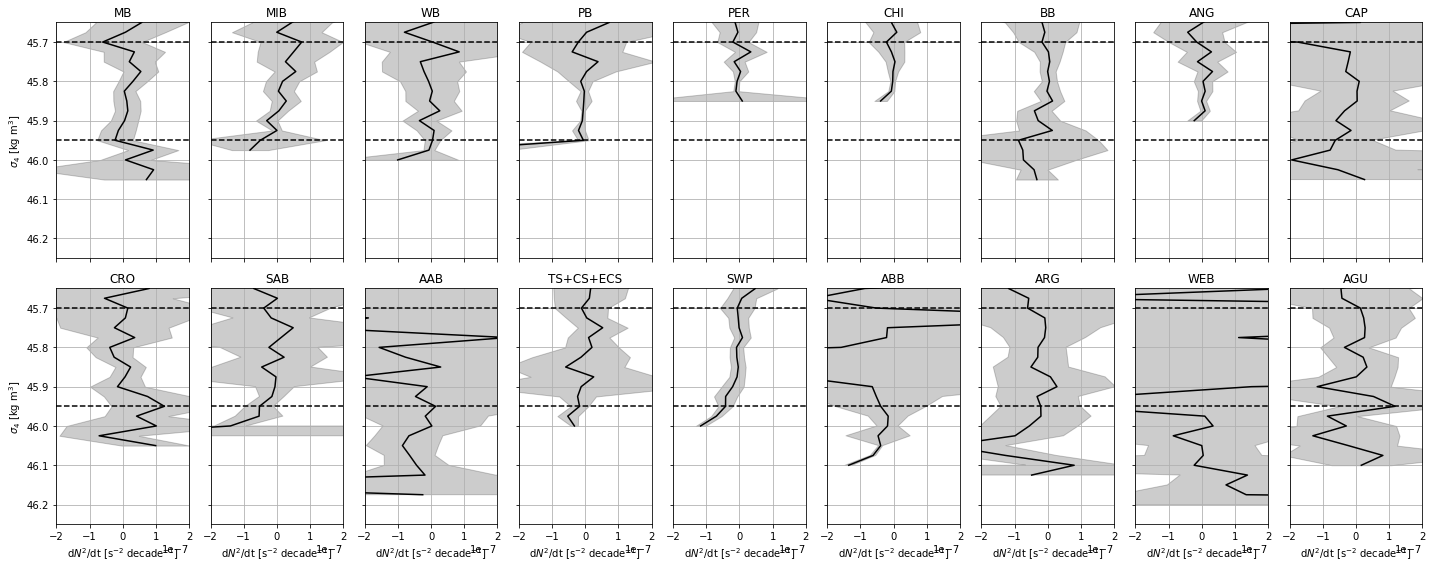

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(20, 8))
for idx in range(len(idx_[0])):
    if ~np.isnan(idx_[0,idx]):
        idx_basin, var_keys = within_basin(var_lon, var_lat, int(idx_[0,idx]))
        N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :], var_err[idx_basin, :], var_eDOF[idx_basin, :])
#         ax[0,idx].plot(N2_trend_z_sh, z_N2, color='b', label='south of 60$^{\circ}$S')
#         ax[0,idx].fill_betweenx(z_N2, 
#                          N2_trend_CI_z_sh[:,0],
#                          N2_trend_CI_z_sh[:,1],
#                          color='b', alpha=.2)  
        ax[0,idx].plot(N2_trend_z, z_N2, color='k')
        ax[0,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z[:,0],
                         N2_trend_CI_z[:,1],
                         color='k', alpha=.2)  
        ax[0,idx].set_ylim([param_plot['sig1_lw'], param_plot['sig1_up']])
        ax[0,idx].set_xlim([-2e-07, 2e-07])
        ax[0,idx].grid(True)
        if idx == 0:
            ax[0,idx].set_ylabel('$\sigma_4$ [kg m$^3$]')
        if idx > 0:
            ax[0,idx].set_yticklabels([])
        ax[0,idx].set_xticklabels([])
        ax[0,idx].set_title(var_keys[idx_[0,idx]][0])
        for i in range(len(z_thred)):
            ax[0,idx].plot([-2e-07, 2e-07], [z_thred[i], z_thred[i]], 'k--')
        
for idx in range(len(idx_[1])):
    if ~np.isnan(idx_[1,idx]):
        idx_basin, var_keys = within_basin(var_lon, var_lat, int(idx_[1,idx]))
        N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :], var_err[idx_basin, :], var_eDOF[idx_basin, :])
#         ax[1,idx].plot(N2_trend_z_sh, z_N2, color='b', label='south of 60$^{\circ}$S')
#         ax[1,idx].fill_betweenx(z_N2, 
#                          N2_trend_CI_z_sh[:,0],
#                          N2_trend_CI_z_sh[:,1],
#                          color='b', alpha=.2)  
        ax[1,idx].plot(N2_trend_z, z_N2, color='k')
        ax[1,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z[:,0],
                         N2_trend_CI_z[:,1],
                         color='k', alpha=.2)  
        ax[1,idx].set_ylim([param_plot['sig1_lw'], param_plot['sig1_up']])
        ax[1,idx].set_xlim([-2e-07, 2e-07])
        ax[1,idx].grid(True)
        if idx == 0:
            ax[1,idx].set_ylabel('$\sigma_4$ [kg m$^3$]')
        if idx > 0:
            ax[1,idx].set_yticklabels([])
        ax[1,idx].set_title(var_keys[idx_[1,idx]][0])
        ax[1,idx].set_xlabel('d$N^2$/dt [s$^{-2}$ decade$^{-1}$]')
        for i in range(len(z_thred)):
            ax[1,idx].plot([-2e-07, 2e-07], [z_thred[i], z_thred[i]], 'k--')
    else:
        idx_basin1, _ = within_basin(var_lon, var_lat, 9)
        idx_basin2, _ = within_basin(var_lon, var_lat, 7)
        idx_basin3, _ = within_basin(var_lon, var_lat, 32)
        idx_basin = (idx_basin1) | (idx_basin2) | (idx_basin3)
        N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :], var_err[idx_basin, :], var_eDOF[idx_basin, :])
#         ax[1,idx].plot(N2_trend_z_sh, z_N2, color='b', label='south of 60$^{\circ}$S')
#         ax[1,idx].fill_betweenx(z_N2, 
#                          N2_trend_CI_z_sh[:,0],
#                          N2_trend_CI_z_sh[:,1],
#                          color='b', alpha=.2)  
        ax[1,idx].plot(N2_trend_z, z_N2, color='k')
        ax[1,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z[:,0],
                         N2_trend_CI_z[:,1],
                         color='k', alpha=.2)  
        ax[1,idx].set_ylim([param_plot['sig1_lw'], param_plot['sig1_up']])
        ax[1,idx].set_xlim([-2e-07, 2e-07])
        ax[1,idx].grid(True)
        if idx == 0:
            ax[1,idx].set_ylabel('$\sigma_4$ [kg m$^3$]')
        if idx > 0:
            ax[1,idx].set_yticklabels([])
        ax[1,idx].set_title('TS+CS+ECS')
        ax[1,idx].set_xlabel('d$N^2$/dt [s$^{-2}$ decade$^{-1}$]')
        for i in range(len(z_thred)):
            ax[1,idx].plot([-2e-07, 2e-07], [z_thred[i], z_thred[i]], 'k--')
        
plt.tight_layout()
plt.savefig(outfilepath+ 'selected_basins_N2trend_mean_sig4.jpeg', dpi=300)
plt.savefig(outfilepath+ 'selected_basins_N2trend_mean_sig4.eps')

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3825476075.py:5: RuntimeWarning: Mean of empty slice
  N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[idx_basin, :])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3825476075.py:5: RuntimeWarning: Mean of empty slice
  N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[idx_basin, :])
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/3825476075.py:5: RuntimeWarning: Mean of empty slice
  N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[idx_basin, :])
/var/folders/sr/6_bkfhj929364hv72k

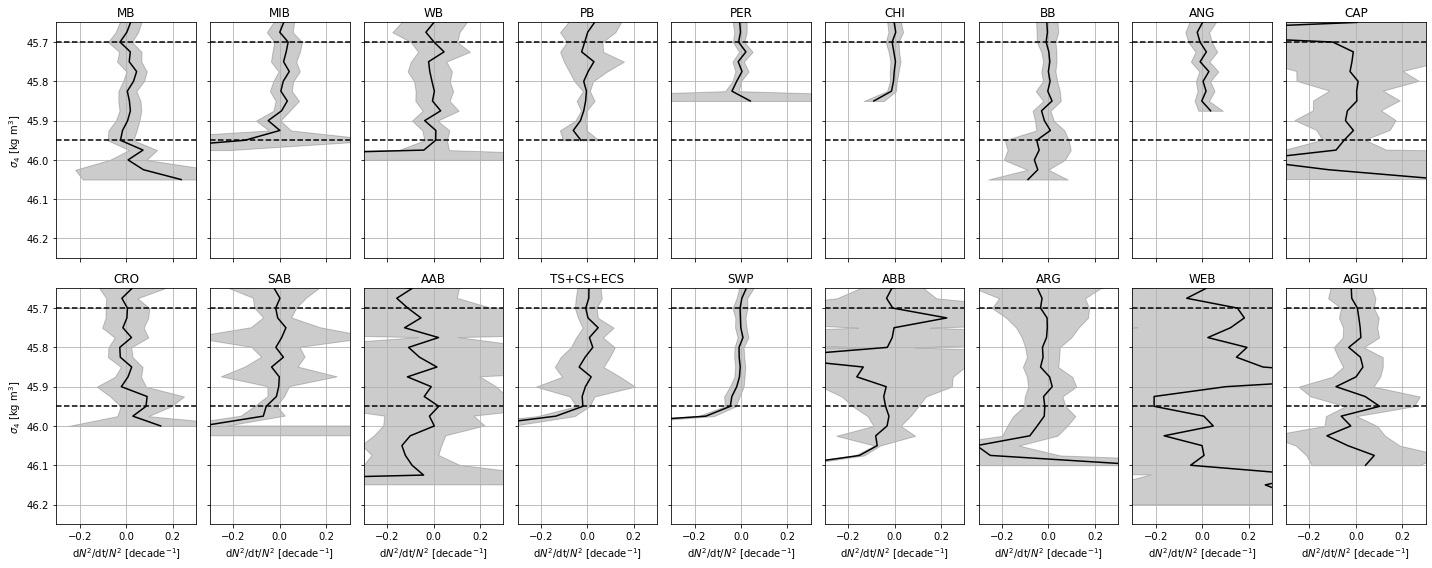

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(20, 8))
for idx in range(len(idx_[0])):
    if ~np.isnan(idx_[0,idx]):
        idx_basin, var_keys = within_basin(var_lon, var_lat, int(idx_[0,idx]))
        N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[idx_basin, :])
#         ax[0,idx].plot(N2_trend_z_sh, z_N2, color='b', label='south of 60$^{\circ}$S')
#         ax[0,idx].fill_betweenx(z_N2, 
#                          N2_trend_CI_z_sh[:,0],
#                          N2_trend_CI_z_sh[:,1],
#                          color='b', alpha=.2)  
        ax[0,idx].plot(N2_trend_z, z_N2, color='k')
        ax[0,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z[:,0],
                         N2_trend_CI_z[:,1],
                         color='k', alpha=.2)  
        ax[0,idx].set_ylim([param_plot['sig1_lw'], param_plot['sig1_up']])
        ax[0,idx].set_xlim([-.3,.3])
        ax[0,idx].grid(True)
        if idx == 0:
            ax[0,idx].set_ylabel('$\sigma_4$ [kg m$^3$]')
        if idx > 0:
            ax[0,idx].set_yticklabels([])
        ax[0,idx].set_xticklabels([])
        ax[0,idx].set_title(var_keys[idx_[0,idx]][0])
        for i in range(len(z_thred)):
            ax[0,idx].plot([-.3, .3], [z_thred[i], z_thred[i]], 'k--')
        
for idx in range(len(idx_[1])):
    if ~np.isnan(idx_[1,idx]):
        idx_basin, var_keys = within_basin(var_lon, var_lat, int(idx_[1,idx]))
        N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[idx_basin, :])
#         ax[1,idx].plot(N2_trend_z_sh, z_N2, color='b', label='south of 60$^{\circ}$S')
#         ax[1,idx].fill_betweenx(z_N2, 
#                          N2_trend_CI_z_sh[:,0],
#                          N2_trend_CI_z_sh[:,1],
#                          color='b', alpha=.2)  
        ax[1,idx].plot(N2_trend_z, z_N2, color='k')
        ax[1,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z[:,0],
                         N2_trend_CI_z[:,1],
                         color='k', alpha=.2)  
        ax[1,idx].set_ylim([param_plot['sig1_lw'], param_plot['sig1_up']])
        ax[1,idx].set_xlim([-.3, .3])
        ax[1,idx].grid(True)
        if idx == 0:
            ax[1,idx].set_ylabel('$\sigma_4$ [kg m$^3$]')
        if idx > 0:
            ax[1,idx].set_yticklabels([])
        ax[1,idx].set_title(var_keys[idx_[1,idx]][0])
        ax[1,idx].set_xlabel('d$N^2$/dt/$N^2$ [decade$^{-1}$]')
        for i in range(len(z_thred)):
            ax[1,idx].plot([-.3, .3], [z_thred[i], z_thred[i]], 'k--')
    else:
        idx_basin1, _ = within_basin(var_lon, var_lat, 9)
        idx_basin2, _ = within_basin(var_lon, var_lat, 7)
        idx_basin3, _ = within_basin(var_lon, var_lat, 32)
        idx_basin = (idx_basin1) | (idx_basin2) | (idx_basin3)
        N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[idx_basin, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[idx_basin, :])
#         ax[1,idx].plot(N2_trend_z_sh, z_N2, color='b', label='south of 60$^{\circ}$S')
#         ax[1,idx].fill_betweenx(z_N2, 
#                          N2_trend_CI_z_sh[:,0],
#                          N2_trend_CI_z_sh[:,1],
#                          color='b', alpha=.2)  
        ax[1,idx].plot(N2_trend_z, z_N2, color='k')
        ax[1,idx].fill_betweenx(z_N2, 
                         N2_trend_CI_z[:,0],
                         N2_trend_CI_z[:,1],
                         color='k', alpha=.2)  
        ax[1,idx].set_ylim([param_plot['sig1_lw'], param_plot['sig1_up']])
        ax[1,idx].set_xlim([-.3, .3])
        ax[1,idx].grid(True)
        if idx == 0:
            ax[1,idx].set_ylabel('$\sigma_4$ [kg m$^3$]')
        if idx > 0:
            ax[1,idx].set_yticklabels([])
        ax[1,idx].set_title('TS+CS+ECS')
        ax[1,idx].set_xlabel('d$N^2$/dt/$N^2$ [decade$^{-1}$]')
        for i in range(len(z_thred)):
            ax[1,idx].plot([-.3, .3], [z_thred[i], z_thred[i]], 'k--')
        
plt.tight_layout()
plt.savefig(outfilepath+ 'selected_basins_N2trend_percentage_sig4.jpeg', dpi=300)
plt.savefig(outfilepath+ 'selected_basins_N2trend_percentage_sig4.eps')

### 3. Brazil basin

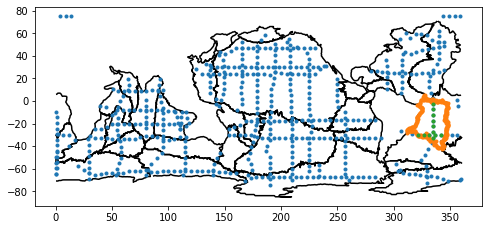

In [21]:
basin = sio.loadmat('../data/bsn_boundary.mat', squeeze_me=True, struct_as_record=False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

for i in range(len(basin['bsn_only'])):
    lon = basin['bsn_only'][i].bsn[0].copy()
    lat = basin['bsn_only'][i].bsn[1].copy()
    lon_ = lon.copy()
    lat_ = lat.copy()
    lon__ = lon.copy()
    lat__ = lat.copy()    
    lat[(lon<0) | (lon>360)] = np.nan
    lon[(lon<0) | (lon>360)] = np.nan
    ax.plot(lon,  lat, c='k')
    lat_[lon_>=0] = np.nan
    lon_[lon_>=0] = np.nan
    lon_[lon_<0] += 360
    ax.plot(lon_, lat_, c='k')
    lat__[lon__<=360] = np.nan
    lon__[lon__<=360] = np.nan
    lon__[lon__>=360] -= 360
    ax.plot(lon__, lat__, c='k')
    
ax.plot(var_lon, var_lat, '.')
ax.set_aspect('equal')

k=15
var_mask, var_keys = within_basin(var_lon, var_lat, k)
ax.plot(basin['bsn_only'][k].bsn[0], basin['bsn_only'][k].bsn[1], '.-')
ax.plot(var_lon[var_mask], var_lat[var_mask], '.')


# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
# for i in range(len(basin['bsn_only'])):
#     ax.plot(basin['bsn_only'][i].bsn[0], basin['bsn_only'][i].bsn[1], c='k')

In [22]:
N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[var_mask, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[var_mask, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[var_mask, :])
print(N2_trend_z, z_N2)

[ 0.0089012  -0.02572262 -0.00742698 -0.00367493 -0.00839921  0.001223
  0.00414894 -0.00016667  0.00463436 -0.00203098  0.01348436 -0.03610295
 -0.02095664  0.01050219 -0.0765254  -0.05490733 -0.05513794 -0.03934479
 -0.04960463         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan] [45.6   45.625 45.65  45.675 45.7   45.725 45.75  45.775 45.8   45.825
 45.85  45.875 45.9   45.925 45.95  45.975 46.    46.025 46.05  46.075
 46.1   46.125 46.15  46.175 46.2   46.225 46.25  46.275 46.3   46.325
 46.35  46.375 46.4  ]


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/1690273962.py:1: RuntimeWarning: Mean of empty slice
  N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var[var_mask, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_err[var_mask, :]/np.nanmean(N2_z_[idx_basin,:], axis=0), var_eDOF[var_mask, :])


In [23]:
import pandas as pd

Data_trend_BB = xr.open_dataset("/Users/stan/Desktop/WORK/DATA/GOSHIP/EasyOcean/gridded/a16-a23_sig4_trend.nc")
N2_z_BB = xr.open_dataset("/Users/stan/Desktop/WORK/DATA/GOSHIP/EasyOcean/gridded/a16-a23_sig4_block.nc")
ll = N2_z_BB.LL_st.data
N2_z_BB_ = N2_z_BB.N2_mean.data[:,(ll>=-40) & (ll<=0),:]
var_BB = eval("Data_trend_BB.trend_N2_mean.data")[(ll>=-40) & (ll<=0),:]
var_err_BB = eval("Data_trend_BB.trend_N2_err.data")[(ll>=-40) & (ll<=0),:]
var_eDOF_BB = eval("Data_trend_BB.eDOF.data")[(ll>=-40) & (ll<=0),:]
N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var_BB/np.nanmean(N2_z_BB_, axis=0), var_err_BB/np.nanmean(N2_z_BB_, axis=0), var_eDOF_BB)
print(pd.DataFrame(np.array([N2_trend_z, z_N2]).T, columns=['N2_trend', 'z_N2']))

    N2_trend    z_N2
0  -0.021349  45.600
1  -0.044407  45.625
2   0.006239  45.650
3   0.000894  45.675
4  -0.003867  45.700
5   0.000370  45.725
6   0.002428  45.750
7  -0.010889  45.775
8   0.014142  45.800
9   0.011314  45.825
10  0.000663  45.850
11 -0.028149  45.875
12 -0.003338  45.900
13 -0.015931  45.925
14 -0.011674  45.950
15 -0.038703  45.975
16 -0.055920  46.000
17 -0.071493  46.025
18 -0.125574  46.050
19       NaN  46.075
20       NaN  46.100
21       NaN  46.125
22       NaN  46.150
23       NaN  46.175
24       NaN  46.200
25       NaN  46.225
26       NaN  46.250
27       NaN  46.275
28       NaN  46.300
29       NaN  46.325
30       NaN  46.350
31       NaN  46.375
32       NaN  46.400


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25276/825128138.py:10: RuntimeWarning: Mean of empty slice
  N2_trend_z, N2_trend_err_z, N2_trend_CI_z = err_from_mean(var_BB/np.nanmean(N2_z_BB_, axis=0), var_err_BB/np.nanmean(N2_z_BB_, axis=0), var_eDOF_BB)


In [24]:
N2_trend_z[(z_N2>=45.85) & (z_N2<=45.95)].mean(), z_N2[(z_N2>=45.85) & (z_N2<=45.95)]

(-0.011685742340383611, array([45.85 , 45.875, 45.9  , 45.925, 45.95 ]))